### Model 3

Transfer Learning

### Transfer Learning and using pre-trained models

Transfer Learning allows us to use pre-trained models trained on datasets with millions of images such as COCO, Imagenet etc. This means instead of building a model from scratch to solve a similar dataset, we can use the model trained on some other dataset as a starting point. Hence by using pre-trained models which have been previously trained on large datasets, we can directly use the weights and architecture obtained and apply the learning on our problem statement and allow us to reach a better accuracy than any method.

For our problem, we are going to the VGG16 model which is available in Keras already. It is Deep convolutional network for object recognition developed and trained by Oxford's renowned Visual Geometry Group (VGG), which achieved very on the ImageNet dataset.

In [1]:
%matplotlib inline
import os
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras import metrics
from keras.callbacks import EarlyStopping, History, ModelCheckpoint
from keras.layers.core import Flatten, Dense, Dropout, Reshape, Lambda
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.
C:\Users\Anant\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Anant\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Anant\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Anant\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
# Dimension for our images
img_width, img_height = 150, 150

# Directories containing image
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

In [3]:
import os

nor_train_dir = 'data/train/normal/'
nor_valid_dir = 'data/validation/normal/'
abnor_train_dir = 'data/train/abnormal/'
abnor_valid_dir = 'data/validation/abnormal/'

nor_train = len(next(os.walk(nor_train_dir))[2])
nor_valid = len(next(os.walk(nor_valid_dir))[2])
abnor_train = len(next(os.walk(abnor_train_dir))[2])
abnor_valid = len(next(os.walk(abnor_valid_dir))[2])

## We subtract 1 since every directory has a hidden file .DS_Store
print ('Number of samples in training set (normal): {}'.format((nor_train)-1))
print ('Number of samples in validation set (normal): {}'.format((nor_valid)-1))
print ('Number of samples in training set (abnormal): {}'.format((abnor_train)-1))
print ('Number of samples in validation set (abnormal): {}'.format((abnor_valid)-1))

Number of samples in training set (normal): 599
Number of samples in validation set (normal): 142
Number of samples in training set (abnormal): 399
Number of samples in validation set (abnormal): 81


In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True
        )

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# automagically retrieve images and their classes for train and validation sets
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=4,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=4,
        class_mode='binary')

Found 1000 images belonging to 2 classes.
Found 225 images belonging to 2 classes.


In [6]:
import keras.backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

In [7]:
import matplotlib.pyplot as plt
def results(history):
    # Accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy']); plt.plot(history.history['val_accuracy']);
    plt.title('model accuracy'); plt.ylabel('accuracy');
    plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss']); plt.plot(history.history['val_loss']);
    plt.title('model loss'); plt.ylabel('loss');
    plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
    plt.show()

### Model 3

In [8]:
# example of loading the vgg16 model
from keras.applications.vgg16 import VGG16
# load model
model = VGG16()
# summarize the model
model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0    

In [9]:
from keras.applications.vgg16 import preprocess_input


In [10]:
model = VGG16(include_top=False, input_shape=(150, 150, 3))

In [11]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [12]:
#freeze the weights for these layers
for layer in model.layers:
	layer.trainable = False

In [13]:
## mark some layers as trainable
#model.get_layer('block1_conv1').trainable = True
#model.get_layer('block1_conv2').trainable = False
#model.get_layer('block2_conv1').trainable = False
#model.get_layer('block2_conv2').trainable = False

In [14]:
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(1, activation='sigmoid')(class1)
# define new model
model = keras.Model(inputs=model.inputs, outputs=output)

In [15]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy',precision,recall,fbeta_score])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
nb_epoch = 3
nb_train_samples = 1000
nb_validation_samples = 225

In [18]:
history = model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples)

C:\Users\Anant\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
C:\Users\Anant\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., steps_per_epoch=250, epochs=3, validation_steps=225)`
  



Epoch 1/3
250/250 [==============================] - 21s 82ms/step - loss: 0.7401 - accuracy: 0.6580 - precision: 0.6373 - recall: 0.7277 - fbeta_score: 0.6412 - val_loss: 0.5812 - val_accuracy: 0.4276 - val_precision: 0.4441 - val_recall: 0.3022 - val_fbeta_score: 0.3341
Epoch 2/3
250/250 [==============================] - 19s 75ms/step - loss: 0.5786 - accuracy: 0.7200 - precision: 0.7223 - recall: 0.8183 - fbeta_score: 0.7322 - val_loss: 0.8847 - val_accuracy: 0.4662 - val_precision: 0.3963 - val_recall: 0.2022 - val_fbeta_score: 0.2551- fbeta_score - ETA: 1s - loss: 0.5896 - accuracy: 0.7093 - precision: 0.7115 - recall: 0.8025 - fbeta_s
Epoch 3/3
250/250 [==============================] - 19s 76ms/step - loss: 0.5410 - accuracy: 0.7270 - precision: 0.7297 - recall: 0.8110 - fbeta_score: 0.7320 - val_loss: 0.6610 - val_accuracy: 0.4741 - val_precision: 0.4867 - val_recall: 0.2881 - val_fbeta_score: 0.3375: 0.5444 - accuracy: 0.7259 - precision: 0.7282 - recall: 0.8070 - fbe


In [19]:
model.evaluate_generator(validation_generator, nb_validation_samples) ## [Loss,
                                                                      ##  Accuracy,
                                                                      ##  Precision,
                                                                      ##  Recall
                                                                      ##  F-BetaScore]

[1.158618450164795,
 0.47362515330314636,
 0.4977777302265167,
 0.2888888418674469,
 0.340867817401886]

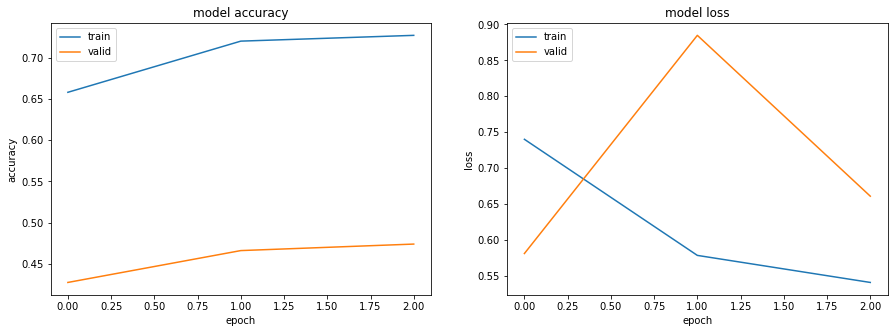

In [20]:
results(history)